# Purpose: Old normalization algorithm, which used a GPU accelerated version of ZScale
Repeatedly runs a line fit on the brightnesses of pixels in an image to find proper high and low bounds. Very computationally expensive so I ended up using a different normalization algorithm.

In [11]:
from astropy.io import fits
import glob
import matplotlib.pyplot as plt
import matplotlib
from astropy.visualization import LinearStretch, ZScaleInterval, ImageNormalize
import numpy as np
import random
import tensorflow as tf
import numba
import scipy.stats as stats
import skimage.transform
import cupy as cp
import os
import sigpy
from keras.models import load_model
from cupyx.scipy.ndimage.filters import convolve
matplotlib.rc('image', cmap='gray')
size = 80

In [2]:
filenames = glob.glob("/media/rd1/ztf_neos/training_examples/aligned/*")

In [3]:
# generated from generate_streak_distribution.py
params_gamma_width = [4.79235037, 11.40523025, 1.64361626]
params_gamma_amplitude = [1.09717868, 1.99999993, 3.7169828]
params_gamma_length = [4.16396709, 8.0180058, 2.68969172]

gain = 6.2

amp_factor = 1.5

def gaussian(x, offset, std, amp):
    return amp * np.exp(-np.power(x - offset, 2.) / (2 * np.power(std, 2.)))


def gaussian_streak(width, offset, std, amp, bkg):
    dist = gaussian(np.arange(width), offset, std, amp) + bkg
    return dist

def implant_random_streak(image):

    image = np.copy(image)

    while True:
        std = stats.gamma.rvs(*params_gamma_width) * 0.05
        width = std * 10

        if random.random() < 0.7:
            length = stats.gamma.rvs(*params_gamma_length)
        else:
            length = np.random.random() * 30 + 10

        # use 2*std, which is "real" width
        if length / (std * 2) > 2 and length > 10 and width > 0:
            break

    streak = np.repeat(np.array([gaussian_streak(width, width / 2, std, 1, 0)]).T, length, axis=1)
    rotation = np.random.uniform(0, 360)
    streak = skimage.transform.rotate(streak, rotation, resize=True, order=3)

    y_len, x_len = image.shape
    y_len_streak, x_len_streak = streak.shape
    x_streak = np.random.randint(0, x_len - x_len_streak)
    y_streak = np.random.randint(0, y_len - y_len_streak)

    amp_min = np.std(image[y_streak:y_streak + y_len_streak, x_streak:x_streak + x_len_streak]) * amp_factor

    if random.random() < 0.9:
        amplitude = amp_min * (1 + abs(np.random.randn()))
    else:
        amplitude = (np.random.random() * 5) * amp_min

    streak *= amplitude

    # add shot noise
    streak = np.random.poisson(streak * gain)

    streak = streak / gain
    shape = streak.shape
    image[y_streak:y_streak + shape[0], x_streak:x_streak + shape[1]] += streak

    return image

In [4]:
min_npixels = 5
krej = 2.5
max_iterations = 5
max_reject = 0.5
contrast = 0.5
def normalize(image):
    with tf.device('/GPU:0'):
        images = tf.constant(np.expand_dims([image], -1))
        patches = tf.extract_image_patches(images=images,
                                           ksizes=[1, size, size, 1],
                                           strides=[1, size * 0.5, size * 0.5, 1],
                                           rates=[1, 1, 1, 1],
                                           padding='VALID')
        patches = sess.run(patches)
        
        images = np.reshape(patches, (patches.shape[1], patches.shape[2], size, size))
#         patches = tf.sort(patches)
        
#         images, samples = sess.run([images, patches])

        samples = np.sort(images)
        npix = np.shape(samples)[-1]
        
        # Fit a line to the sorted array of samples
        minpix = max(min_npixels, int(npix * max_reject))
        x = np.arange(npix)
        ngoodpix = np.ones(np.shape(samples)[:-1]) * npix
        last_ngoodpix = np.ones(np.shape(samples)[:-1]) * (npix + 1)

        # Bad pixels mask used in k-sigma clipping
        badpix = np.zeros(np.shape(samples), dtype=bool)

        # Kernel used to dilate the bad pixels mask
        ngrow = max(1, int(npix * 0.01))
        kernel = np.ones(ngrow, dtype=bool)
        
        notdone = np.ones(np.shape(samples)[:-1])

        for niter in range(max_iterations):
            
            notdone = np.logical_or(ngoodpix < last_ngoodpix, ngoodpix >= minpix)
                
            fit = np.polyfit(x, samples, deg=1, w=(~badpix).astype(int))
            fitted = np.poly1d(fit)(x)

            # Subtract fitted line from the data array
            flat = samples - fitted

            # Compute the k-sigma rejection threshold
            threshold = krej * flat[~badpix].std()

            # Detect and reject pixels further than k*sigma from the
            # fitted line
            badpix[(flat < - threshold) | (flat > threshold)] = True

            # Convolve with a kernel of length ngrow
            badpix = np.convolve(badpix, kernel, mode='same')

            last_ngoodpix = ngoodpix
            ngoodpix = np.sum(~badpix)

In [5]:
X = tf.placeholder("float")
Y = tf.placeholder("float")

W = tf.Variable(np.random.randn(), name="weight")
b = tf.Variable(np.random.randn(), name="bias")
    
def line_fit(x, y, weight):
    x = x[weight == 1]
    y = y[weight == 1]
    
    n_samples = len(x)

    # Construct a linear model
    pred = tf.add(tf.multiply(X, W), b)

    # Mean squared error
    cost = tf.reduce_sum(tf.pow(pred-Y, 2))/(2*n_samples)
    
    # Gradient descent
    #  Note, minimize() knows to modify W and b because Variable objects are trainable=True by default
    optimizer = tf.train.GradientDescentOptimizer(0.0000001).minimize(cost)
    
    init = tf.global_variables_initializer()
    
    sess.run(init)
    for i in range(10):
        sess.run(optimizer, feed_dict={X: x, Y: y})
#         print(sess.run(cost, feed_dict={X: x, Y:y}))

    return sess.run(W), sess.run(b)


#OLD: Numba (Not cuda but I think it uses C to speed up operations)
# @numba.njit()
# def linear_regression(Y, X, w, b, iterations, alphaN):
#     for i in range(iterations):
#         w -= alphaN * np.dot(X.transpose(), np.multiply(w, X) + b - Y)
#         b -= alphaN * np.sum(w*X + b - Y)
# #     print(w, b)
# #     print(type(w), type(b))
# #     print(np.sum((w*X + b - Y)**2))
#     return w, b


def linear_regression(Y, X, w, b, iterations, alphaN):
    for i in range(iterations):
        w -= alphaN * cp.dot(X.transpose(), cp.multiply(w, X) + b - Y)
        b -= alphaN * cp.sum(w*X + b - Y)
#     print(w, b)
#     print(type(w), type(b))
#     print(np.sum((w*X + b - Y)**2))
    return w.item(), b.item()


def line_fit_2(x, y, weight):
    x = np.array(x[weight == 1], dtype="float64")
    y = np.array(y[weight == 1], dtype="float64")
    
    n_samples = len(x)
    
    alphaN = 0.000002/n_samples
    
    return linear_regression(cp.array(y), cp.array(x), 0, 0, 10, alphaN)


# @numba.njit()
# def convolve()


def normalize(arr, nsamples, use_cuda=False, convolve=False):
    arr = np.copy(arr)
    values = np.asarray(arr)
    values = values[np.isfinite(values)]
    stride = int(max(1.0, values.size / nsamples))
    samples = values[::stride][:nsamples]
    samples.sort()

    npix = len(samples)
    vmin = samples[0]
    vmax = samples[-1]

    # Fit a line to the sorted array of samples
    minpix = max(min_npixels, int(npix * max_reject))
    x = np.arange(npix)
    ngoodpix = npix
    last_ngoodpix = npix + 1

    # Bad pixels mask used in k-sigma clipping
    badpix = np.zeros(npix, dtype=bool)

    # Kernel used to dilate the bad pixels mask
    ngrow = max(1, int(npix * 0.01))
    kernel = np.ones(ngrow, dtype=bool)

    for niter in range(max_iterations):
        if ngoodpix >= last_ngoodpix or ngoodpix < minpix:
            print("fail")
            break
        
        if use_cuda:
            fit = line_fit_2(x, samples, (~badpix).astype(int))
        else:
            fit = np.polyfit(x, samples, deg=1, w=(~badpix).astype(int))
        fitted = np.poly1d(fit)(x)

        # Subtract fitted line from the data array
        flat = samples - fitted

        # Compute the k-sigma rejection threshold
        threshold = krej * flat[~badpix].std()

        # Detect and reject pixels further than k*sigma from the
        # fitted line
        badpix[(flat < - threshold) | (flat > threshold)] = True

        # Convolve with a kernel of length ngrow NOTE: Don't really need, doesn't do much
        if convolve:
            badpix = np.convolve(badpix, kernel, mode='same')

        last_ngoodpix = ngoodpix
        ngoodpix = np.sum(~badpix)

    slope, intercept = fit

    if ngoodpix >= minpix:
        if contrast > 0:
            slope = slope / contrast
        center_pixel = (npix - 1) // 2
        median = np.median(samples)
        vmin = max(vmin, median - (center_pixel - 1) * slope)
        vmax = min(vmax, median + (npix - center_pixel) * slope)
    
    arr -= vmin
    arr /= vmax - vmin
    
    return np.clip(arr, 0, 1)

In [60]:
def linear_regression(X, Y, w, b, iterations, alphaN, weights):
    
#     print("Start")
#     print(w.shape)
#     print(X.shape)
#     print(b.shape)
#     print(Y.shape)
#     print(weights.shape)
    
    for i in range(iterations):
        diff = cp.multiply(cp.multiply(w, X) + b - Y, weights)
        w -= alphaN * cp.sum(cp.multiply(X, diff), axis=-1, keepdims=True)
        b -= alphaN * cp.sum(diff, axis=-1, keepdims=True)
#     print(w, b)
#     print(type(w), type(b))
#     print(np.sum((w*X + b - Y)**2))
    return w, b


def line_fit_2(x, y, weight):
    
    n_samples = cp.sum(weight, axis=-1, keepdims=True)
    
    alphaN = 0.000002/n_samples
    
    return linear_regression(y, x, 0, 0, 10, alphaN)


def weighted_std(values, weights):
    average = cp.expand_dims(cp.average(values, weights=weights, axis=-1), -1)
    # Fast and numerically precise:
    variance = cp.average((values-average)**2, weights=weights, axis=-1)
    return cp.sqrt(variance)


# for some reason CuPy just doesn't have median function
def get_median(arr):
    size = arr.shape[-1]
    return (arr[:, size//2] + arr[:, size//2 + 1]) / 2


def normalize_cuda(arr, nsamples):
    arr = cp.array(arr)
#     arr = cp.transpose(arr, [0, 3, 1, 2])
#     arr = cp.reshape(arr, (len(arr) * 2, size, size))
    
    values = cp.reshape(arr, (len(arr), size * size))
    stride = (size * size) // nsamples
    
    # need to do this since CuPy doesn't support sorting non-contiguous arrays
    samples = cp.array(values[::, ::stride][::, :nsamples])
#     print(samples.shape)
    samples.sort()
#     print(samples.shape)

    npix = nsamples
    nimage = len(arr)
    
    vmin = samples[:, 0]
    vmax = samples[:, -1]

    x = np.expand_dims(cp.arange(npix), 0)
    ngoodpix = npix

    # pixels mask used in k-sigma clipping
    goodpix = cp.ones((nimage, npix))
    
    slope = cp.zeros((nimage, 1))
    intercept = cp.zeros((nimage, 1))
    
    ngrow = max(1, int(npix * 0.01))
    kernel = cp.ones((1, ngrow))
    
    for niter in range(10):
        
        n_samples = cp.sum(goodpix, axis=-1, keepdims=True)

        alphaN = 0.000002/n_samples
        
        slope, intercept = linear_regression(x, samples, slope, intercept, 10, alphaN, goodpix)
#         fit = line_fit_2(x, samples, (goodpix).astype(int))
        
        fitted = slope * x + intercept

        # Subtract fitted line from the data array
        flat = samples - fitted

        # Compute the k-sigma rejection threshold
        threshold = cp.expand_dims(2.5 * weighted_std(flat, goodpix), -1)

        # Detect and reject pixels further than k*sigma from the
        # fitted line
        goodpix[(flat < - threshold) | (flat > threshold)] = 0

        goodpix = 1 - cp.clip(convolve(1 - goodpix, kernel), 0, 1)
        
    ngoodpix = cp.sum(goodpix, axis=-1)
    
    # can reduce back down to 1D
    slope = slope[:, 0]
    
    if contrast > 0:
        slope = slope / contrast
    center_pixel = (npix - 1) // 2
    median = get_median(samples)
    
    vmin = median - (center_pixel - 1) * slope
    vmax = median + (npix - center_pixel) * slope
    
#     vmin = max(vmin, median - (center_pixel - 1) * slope)
#     vmax = min(vmax, median + (npix - center_pixel) * slope)
    
    vmin = np.reshape(vmin, (len(arr), 1, 1))
    vmax = np.reshape(vmax, (len(arr), 1, 1))
    
    arr -= vmin
    arr /= vmax - vmin
    
    return cp.clip(arr, 0, 1)

In [9]:
sci, ref = np.load(np.random.choice(filenames))
sci_implant = implant_random_streak(sci[800:880, 800:880])
arr = sci_implant

In [14]:
normalize_cuda()

TypeError: normalize_cuda() missing 2 required positional arguments: 'arr' and 'nsamples'

In [137]:
contrast = 0.1
norm, _, _, _ = normalize_cuda(np.array([[arr, arr], [arr, arr]]), size * size//4)

In [10]:
plt.imshow(norm.get(), cmap="gray")
plt.figure()
contrast=0.25
plt.imshow(normalize(arr, size*size//4))

NameError: name 'norm' is not defined

In [59]:
mempool = cp.get_default_memory_pool()
pinned_mempool = cp.get_default_pinned_memory_pool()

In [85]:
mempool.free_all_blocks()
pinned_mempool.free_all_blocks()
print(mempool.used_bytes())              
print(mempool.total_bytes())             
print(pinned_mempool.n_free_blocks())  

0
28778653696
0


In [20]:
cp.cuda.Device(1).use()

In [74]:
del arr

NameError: name 'arr' is not defined

In [76]:
%%time
images = []
indexes = []
for i in range(5):
    sci, ref = np.load(np.random.choice(filenames))
    y_len, x_len = sci.shape
    start = len(images)
    for i in range(0, y_len, 50):
        for j in range(0, x_len, 50):
            if j + size >= x_len or i + size >= y_len:
                continue

            crop_sci = sci[i:i+80, j:j+80]
            crop_ref = ref[i:i+80, j:j+80]

            if np.sum(crop_sci == 0) >= 10 or np.sum(crop_ref == 0) >= 10 or np.sum(np.isnan(crop_sci)) > 0 or np.sum(np.isnan(crop_ref)) > 0:
                continue

    #         sci_norm = normalize(crop_sci, size * size // 4, use_cuda=False)
    #         ref_norm = normalize(crop_ref, size * size // 4, use_cuda=False)
    #         print(i, j)
            images.append([crop_sci, crop_ref])
        
    end = len(images)
    indexes.append((start, end))
    
images = cp.array(images)
images = cp.reshape(images, (-1, 80, 80))
contrast = 0.1
norm_images = normalize_cuda(images, size * size // 4)
norm_images = cp.reshape(norm_images, (-1, 2, size, size))

CPU times: user 3.08 s, sys: 524 ms, total: 3.61 s
Wall time: 7.09 s


In [131]:
%%time
images = []
indexes = []
for i in range(5):
    sci, ref = np.load(np.random.choice(filenames))
    y_len, x_len = sci.shape
    start = len(images)
    for i in range(0, y_len, 50):
        for j in range(0, x_len, 50):
            if j + size >= x_len or i + size >= y_len:
                continue

            crop_sci = sci[i:i+80, j:j+80]
            crop_ref = ref[i:i+80, j:j+80]

            if np.sum(crop_sci == 0) >= 10 or np.sum(crop_ref == 0) >= 10 or np.sum(np.isnan(crop_sci)) > 0 or np.sum(np.isnan(crop_ref)) > 0:
                continue

            sci_norm = normalize(crop_sci, size * size // 4, use_cuda=False)
            ref_norm = normalize(crop_ref, size * size // 4, use_cuda=False)
            images.append([crop_sci, crop_ref])
        
    end = len(images)
    indexes.append((start, end))

CPU times: user 46.8 s, sys: 497 ms, total: 47.3 s
Wall time: 51.6 s


In [15]:
del images
del norm_images

NameError: name 'norm_images' is not defined

In [61]:
%%time
sci, ref = np.load(np.random.choice(filenames))
y_len, x_len = sci.shape

CPU times: user 0 ns, sys: 163 ms, total: 163 ms
Wall time: 981 ms


In [62]:
%%time
images = []
for i in range(0, y_len, 50):
    for j in range(0, x_len, 50):
        if j + size >= x_len or i + size >= y_len:
            continue

        crop_sci = sci[i:i+80, j:j+80]
        crop_ref = ref[i:i+80, j:j+80]

        if np.sum(crop_sci == 0) >= 10 or np.sum(crop_ref == 0) >= 10 or np.sum(np.isnan(crop_sci)) > 0 or np.sum(np.isnan(crop_ref)) > 0:
            continue

        images.append([crop_sci, crop_ref])

CPU times: user 268 ms, sys: 129 µs, total: 268 ms
Wall time: 266 ms


In [1]:
images = cp.array(images)
images = cp.reshape(images, (-1, 80, 80))
contrast = 0.05
norm_images = normalize_cuda(images, size * size // 4)
norm_images = cp.reshape(norm_images, (-1, 2, size, size)).get()

NameError: name 'cp' is not defined

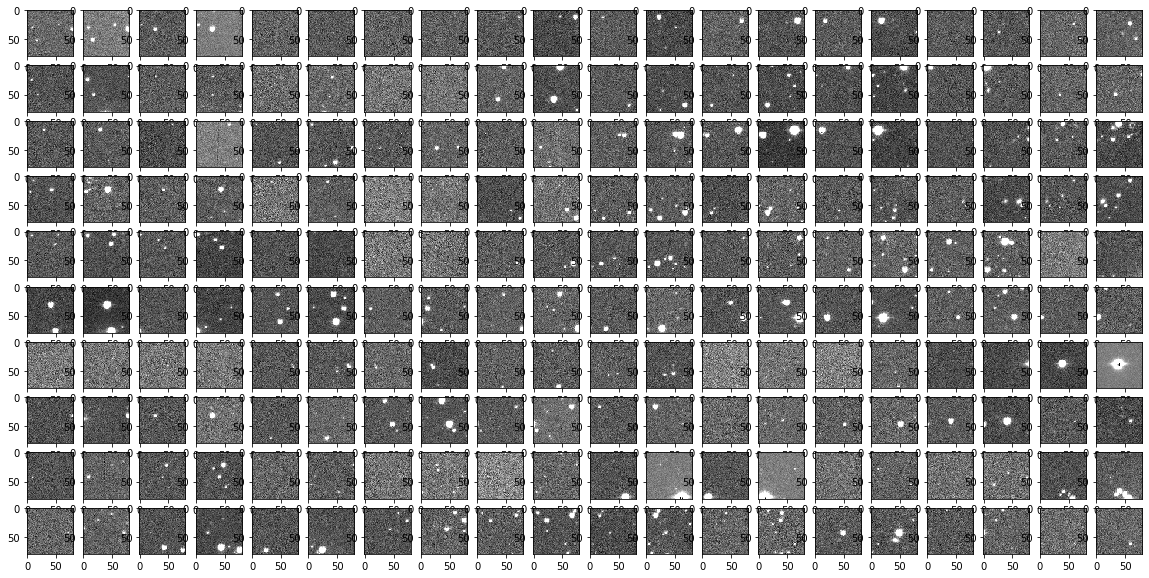

In [69]:
fig, ax = plt.subplots(10, 20, figsize=(20, 10))
ax = ax.flatten()

i = 0
for pair in norm_images[:100]:
    ax[i].imshow(pair[0], cmap="gray")
    ax[i+1].imshow(pair[1], cmap="gray")
    i += 2

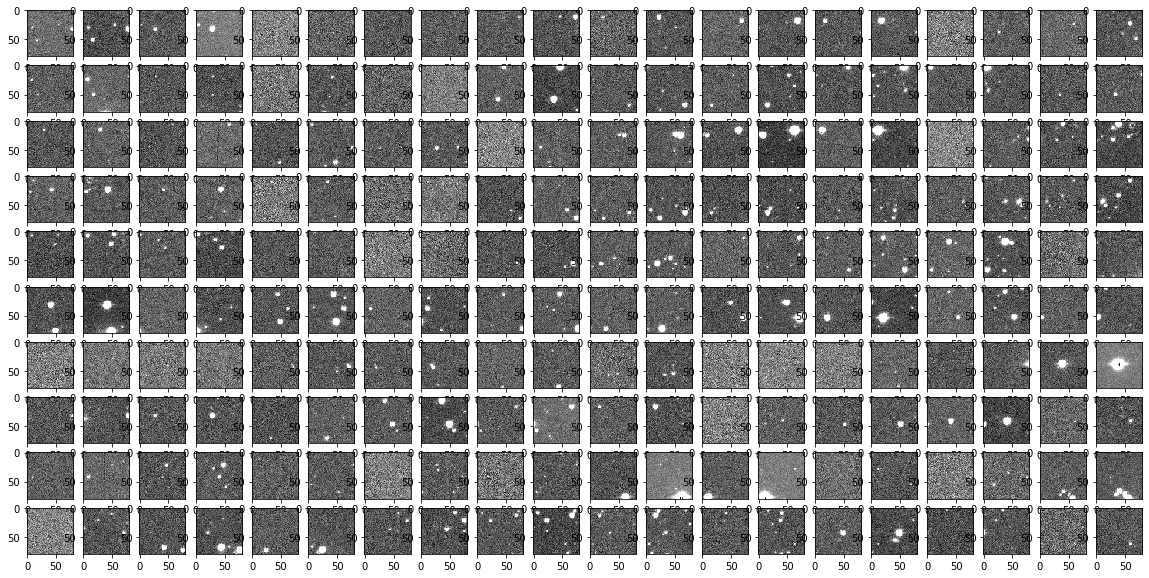

In [67]:
fig, ax = plt.subplots(10, 20, figsize=(20, 10))
ax = ax.flatten()

i = 0
for image in images[:200].get():
    ax[i].imshow(normalize(image, size * size // 4), cmap="gray")
    i += 1

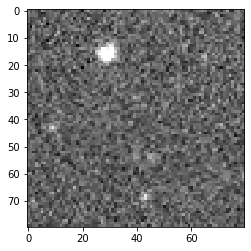

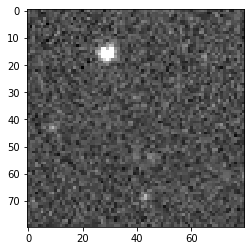

In [65]:
contrast = 0.25
plt.imshow(normalize(images[41].get(), size*size//4), cmap="gray")
plt.figure()
plt.imshow(norm_images[20][1], cmap="gray")

fail


/home/fwang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:134: RuntimeWarning: divide by zero encountered in true_divide
/home/fwang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:134: RuntimeWarning: invalid value encountered in true_divide


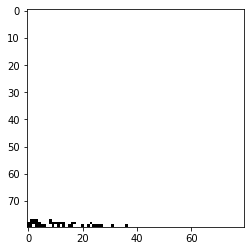

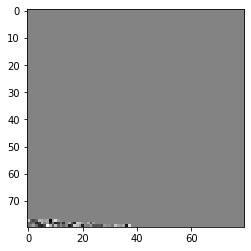

In [73]:
plt.imshow(normalize(sci[100:180, 2500:2580], 80*80//4), cmap="gray")
plt.figure()
plt.imshow(sci[100:180, 2500:2580], cmap="gray")

In [83]:
contrast = 0.1
plt.imshow(normalize(sci[800:880, 800:880], 80*80 // 4, use_cuda=True))
plt.figure()
contrast = 0.25
plt.imshow(normalize(sci[800:880, 800:880], 80*80 // 4, use_cuda=False))
plt.figure()
contrast = 0.1
plt.imshow(normalize(sci_implant, 80*80 // 4, use_cuda=True))
plt.figure()
contrast = 0.25
plt.imshow(normalize(sci_implant, 80*80 // 4, use_cuda=False))

NameError: name 'normalize' is not defined

In [28]:
%%timeit
normalize(sci[800:880, 800:880], 80*80 // 4, use_cuda=True)

9.34 ms ± 5.34 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [187]:
%%timeit
normalize(sci[800:880, 800:880], 80*80 // 4, use_cuda=False)

1.41 ms ± 568 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [188]:
%%timeit
normalize(sci[800:880, 800:880], 80*80, use_cuda=False)

4 ms ± 2.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [53]:
%%timeit
normalize(sci[800:880, 800:880], 80*80 // 4, convolve=False)

1.3 ms ± 1.07 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [52]:
%%timeit
normalize(sci[800:880, 800:880], 80*80 // 4, convolve=True)

1.4 ms ± 826 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [190]:
import numba.cuda
numba.cuda.detect()

Found 2 CUDA devices
id 0    b'GeForce RTX 2080 Ti'                              [SUPPORTED]
                      compute capability: 7.5
                           pci device id: 0
                              pci bus id: 101
id 1     b'GeForce RTX 2070'                              [SUPPORTED]
                      compute capability: 7.5
                           pci device id: 0
                              pci bus id: 23
Summary:
	2/2 devices are supported


True

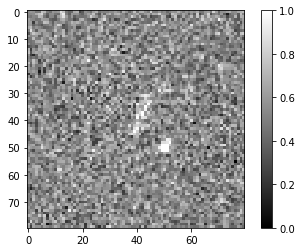

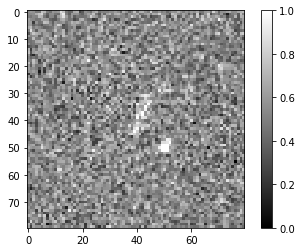

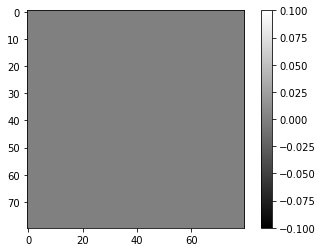

In [43]:
contrast = 0.25
plt.imshow(normalize(sci_implant, 80*80 // 4, use_cuda=False, convolve=True))
plt.colorbar()
plt.figure()
contrast = 0.25
plt.imshow(normalize(sci_implant, 80*80 // 4, use_cuda=False, convolve=False))
plt.colorbar()
plt.figure()
diff = normalize(sci_implant, 80*80 // 4, use_cuda=False, convolve=False) - normalize(sci_implant, 80*80 // 4, use_cuda=False, convolve=True)
plt.imshow(diff)
plt.colorbar()